In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd

In [ ]:
# first set up the parameters
N_E = N_I = 2
r_E = r_I = 0.1
G_E = G_I = 5

tau_1E, tau_2E = 0.5, 0.25
tau_1I, tau_2I = 1, 0.5
E_E, E_I = 50, -100
delta_P_E = delta_P_I = 0.1
a = 10
c = V_rest = -82.7 #mV
b = d =0

n_I = 1/((tau_2I/tau_1I)**(tau_2I/(tau_1I-tau_2I))-(tau_2I/tau_1I)**(tau_1I/(tau_1I-tau_2I)))
n_E = 1/((tau_2E/tau_1E)**(tau_2E/(tau_1E-tau_2E))-(tau_2E/tau_1E)**(tau_1E/(tau_1E-tau_2E)))



In [ ]:
# parameters for Q3a, E only
N_E = N_I = 100
r_E = r_I = 0.1
G_E = 0.4
G_I = 0

tau_1E, tau_2E = 0.5, 0.25
tau_1I, tau_2I = 1, 0.5
E_E, E_I = 50, -100
delta_P_E = delta_P_I = 0.1
a = 10
c = V_rest = -82.7 #mV
b = d =0

n_I = 1/((tau_2I/tau_1I)**(tau_2I/(tau_1I-tau_2I))-(tau_2I/tau_1I)**(tau_1I/(tau_1I-tau_2I)))
n_E = 1/((tau_2E/tau_1E)**(tau_2E/(tau_1E-tau_2E))-(tau_2E/tau_1E)**(tau_1E/(tau_1E-tau_2E)))

In [2]:
# parameters for Q3b, E/I balance
N_E = N_I = 100
r_E = r_I = 0.1
G_E = 20
G_I = 9

tau_1E, tau_2E = 0.5, 0.25
tau_1I, tau_2I = 1, 0.5
E_E, E_I = 50, -100
delta_P_E = delta_P_I = 0.1
a = 10
c = V_rest = -82.7 #mV
b = d =0

n_I = 1/((tau_2I/tau_1I)**(tau_2I/(tau_1I-tau_2I))-(tau_2I/tau_1I)**(tau_1I/(tau_1I-tau_2I)))
n_E = 1/((tau_2E/tau_1E)**(tau_2E/(tau_1E-tau_2E))-(tau_2E/tau_1E)**(tau_1E/(tau_1E-tau_2E)))

In [ ]:
# parameters for test only Q3
N_E = N_I = 10
r_E = r_I = 0.1
G_E = 2
G_I = 0

tau_1E, tau_2E = 0.5, 0.25
tau_1I, tau_2I = 1, 0.5
E_E, E_I = 50, -100
delta_P_E = delta_P_I = 0.1
a = 10
c = V_rest = -82.7 #mV
b = d =0

n_I = 1/((tau_2I/tau_1I)**(tau_2I/(tau_1I-tau_2I))-(tau_2I/tau_1I)**(tau_1I/(tau_1I-tau_2I)))
n_E = 1/((tau_2E/tau_1E)**(tau_2E/(tau_1E-tau_2E))-(tau_2E/tau_1E)**(tau_1E/(tau_1E-tau_2E)))

In [3]:
def synapse(m, v, I, P, A, B, dt, syn_type):
    if syn_type == 'I':
        A += m * delta_P_I * (1-P)
        B += m * delta_P_I * (1-P)

        A_next = A - A * dt/tau_1I
        B_next = B - B * dt/tau_2I
        P_next = n_I * (A_next-B_next)
        I_next = G_I * P * (v-E_I)
        
    elif syn_type == 'E':
        A += m * delta_P_E * (1-P)
        B += m * delta_P_E * (1-P)

        A_next = A - A * dt/tau_1E
        B_next = B - B * dt/tau_2E
        P_next = n_E * (A_next-B_next)
        I_next = G_E * P * (v-E_E)
        
    return I_next, P_next, A_next, B_next


def Izhikevich(u, v, Is, dt):
    dvdt = 0.04 * v**2 + 5 * v + 140 - u - Is
    dudt = a * (b*v-u)
    
    v_next = v + dvdt * dt
    u_next = u + dudt * dt
    
    spike_trigger = 0
    
    if v_next >= 30: # if it fires
        v_next = c
        u_next += d
        spike_trigger = 1
        
    return u_next, v_next, spike_trigger
        
    

In [4]:
class neuron_complex:
    
    def __init__(self, total_steps, dt=0.01):
        self.total_steps = total_steps
        self.dt = dt
        
        # the varibles we should concern
        # u, v, and I, P, A, B respectively for E, I
        # then initialize all the stuff
        self.u = b * V_rest
        self.v = V_rest
        self.I_E = 0
        self.P_E = 0
        self.A_E = 0
        self.B_E = 0
        
        self.I_I = 0
        self.P_I = 0
        self.A_I = 0
        self.B_I = 0
        
        # try to record something
        self.u_record = np.empty(total_steps)
        self.v_record = np.empty(total_steps)
        self.I_E_record = np.empty(total_steps)
        self.I_I_record = np.empty(total_steps)
        self.spike_record = np.empty(total_steps)
        
    def draw_binomial(self):
        # determine all the random inputs once for all
        self.m_E_array = np.random.binomial(N_E, r_E * self.dt, self.total_steps)
        self.m_I_array = np.random.binomial(N_I, r_I * self.dt, self.total_steps)
        
    def envolve(self):
        # now toss the coin!
        
        for step in range(self.total_steps):
            
            
            self.u_record[step] = self.u
            self.v_record[step] = self.v
            self.I_E_record[step] = self.I_E
            self.I_I_record[step] = self.I_I
            
            m_E = self.m_E_array[step].item()
            m_I = self.m_I_array[step].item()
            self.I_E, self.P_E, self.A_E, self.B_E = synapse(m_E, self.v, self.I_E, self.P_E, self.A_E, self.B_E, self.dt, 'E')
            self.I_I, self.P_I, self.A_I, self.B_I = synapse(m_I, self.v, self.I_I, self.P_I, self.A_I, self.B_I, self.dt, 'I')
            
            Is = self.I_E + self.I_I
            self.u, self.v, spike = Izhikevich(self.u, self.v, Is, self.dt)
            self.spike_record[step] = spike
            
            #if int(step * self.dt) % 50 == 0:
                #print(f'now is {int(step * self.dt)}')
            
    def show_record(self):
        return self.u_record, self.v_record, self.I_E_record, self.I_I_record, self.spike_record
        
        
        
        

In [5]:
T = 20000
dt = 0.01
total_steps = int(T/dt)
time_axis = np.linspace(0, T, total_steps)

print(f'total_steps is {total_steps}')
neuron_q2 = neuron_complex(total_steps, dt)

total_steps is 2000000


In [6]:
neuron_q2.draw_binomial()
neuron_q2.envolve()

In [7]:
u_record, v_record, I_E_record, I_I_record, spike_record = neuron_q2.show_record()
m_E_record = neuron_q2.m_E_array
m_I_record = neuron_q2.m_I_array

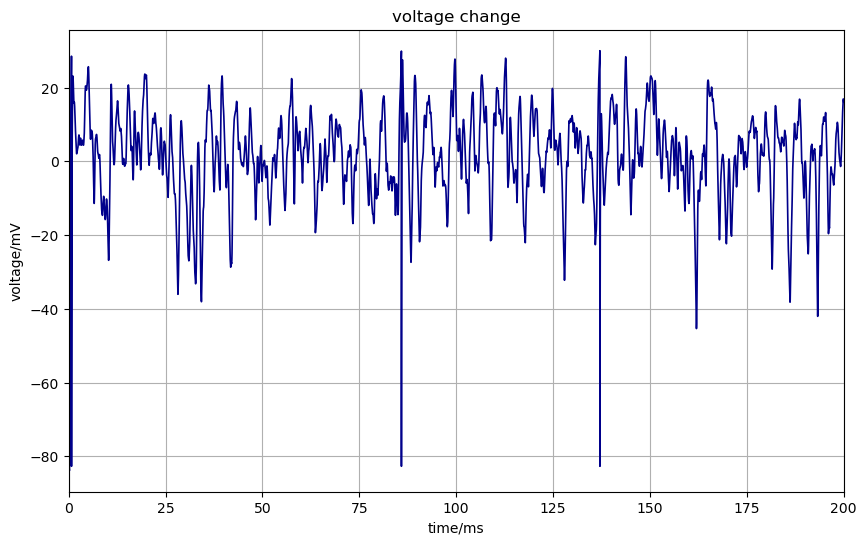

In [8]:

plt.figure(figsize=(10, 6))
plt.plot(time_axis, v_record, color='darkblue', linewidth=1.2)
plt.xlabel('time/ms')
plt.ylabel('voltage/mV')
plt.title('voltage change')
plt.xlim(0, 200)
plt.grid(True)
plt.show()

In [16]:
# compute the mean firing rate

spike_count_list = []
delta_T = 20
delta_steps = int(delta_T/dt)


for i in range(0, len(spike_record), delta_steps):
    smaller_sequence = spike_record[i:i+delta_steps]
    sequence_sum = sum(smaller_sequence)
    spike_count_list.append(sequence_sum)
    
#print(spike_count_list)
mean = np.mean(spike_count_list)
variance = np.var(spike_count_list)
std = np.std(spike_count_list)
print("Mean of the random variable:", mean)
print("Variance of the random variable:", variance)
print('std is', std)
print(f'C={variance/std}')
print(f'the fr is {mean/delta_T}')

Mean of the random variable: 0.268
Variance of the random variable: 0.48017600000000005
std is 0.6929473284456763
C=0.6929473284456764
the fr is 0.0134


In [ ]:
repeat_time = 3
delta_T = 20
delta_steps = int(delta_T/dt)

temp_data = {}
for current_repeat in range(repeat_time):
    spike_count_list = []
    print(current_repeat)
    neuron_temp = neuron_complex(total_steps, dt)
    neuron_temp.draw_binomial()
    neuron_temp.envolve()
    u_record, v_record, I_E_record, I_I_record, spike_record = neuron_temp.show_record()
    
    
    for i in range(0, len(spike_record), delta_steps):
        smaller_sequence = spike_record[i:i+delta_steps]
        sequence_sum = sum(smaller_sequence)
        spike_count_list.append(sequence_sum)
        
    temp_data[f'trial {current_repeat + 1}'] = spike_count_list
    

    

In [ ]:
df = pd.DataFrame(temp_data)

# Create a box plot
#sns.boxplot(data=df)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xlabel('trial')
plt.ylabel('spike count per section')
plt.title('spike counts among sections')
#plt.ylim(0) 

plt.show()
    

In [ ]:
# Example lists containing values of two random variables
rv_values1 = [5, 8, 6, 10, 7, 9, 12, 8, 11, 6]
rv_values2 = [4, 7, 5, 9, 6, 8, 11, 7, 10, 5]

# Combine the values and labels into a single DataFrame
data = {'Random Variable 1': rv_values1, 'Random Variable 2': rv_values2}
df = pd.DataFrame(data)

# Create a box plot
sns.boxplot(data=df)

plt.xlabel('Random Variables')
plt.ylabel('Value')
plt.title('Box Plot of Random Variables')

plt.show()

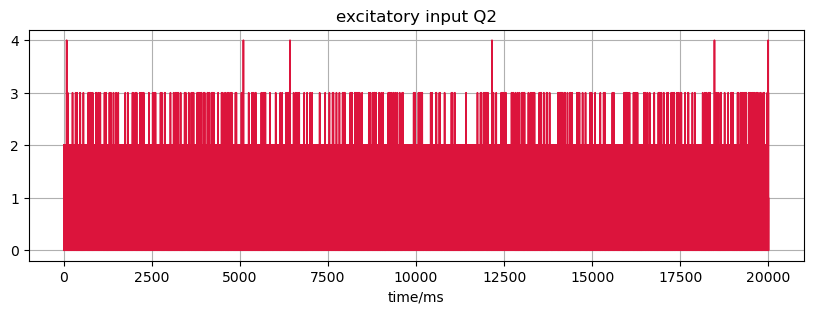

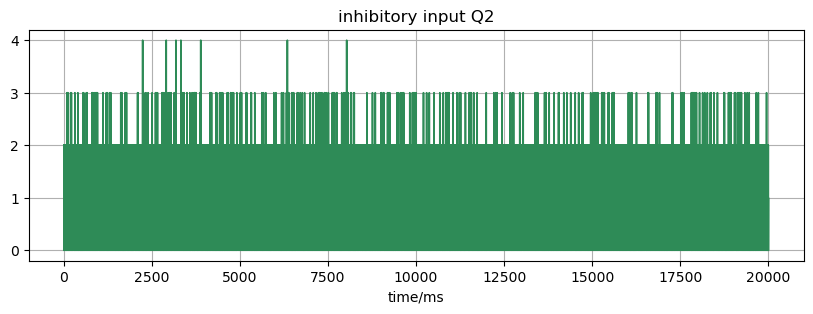

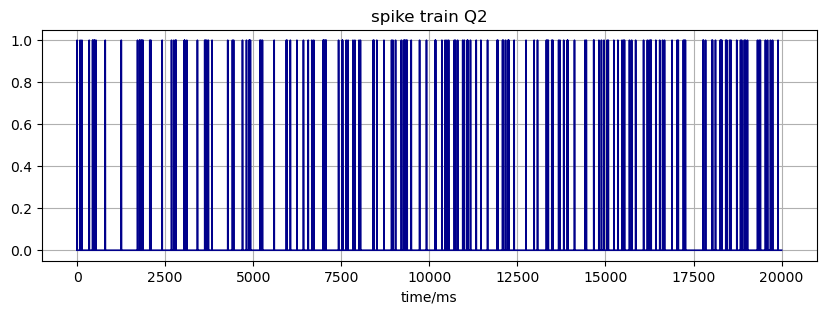

In [10]:
plt.figure(figsize=(10, 3))
plt.plot(time_axis, m_E_record, color='crimson', linewidth=1.2)
plt.xlabel('time/ms')
plt.title('excitatory input Q2')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(time_axis, m_I_record, color='seagreen', linewidth=1.2)
plt.xlabel('time/ms')
plt.title('inhibitory input Q2')
#plt.ylabel('voltage/mV')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(time_axis, spike_record, color='darkblue', linewidth=1.2)
plt.xlabel('time/ms')
#plt.ylabel('voltage/mV')
plt.title('spike train Q2')
plt.grid(True)
plt.show()

In [11]:
print(f'the firing rate of E neurons are {sum(m_E_record)/T} or {sum(m_E_record)/T/N_E}  ')
print(f'the firing rate of I neurons are {sum(m_I_record)/T} or {sum(m_E_record)/T/N_I} ')

the firing rate of E neurons are 10.03015 or 0.1003015  
the firing rate of I neurons are 9.9828 or 0.1003015 


popt is [0.01712858]
r is 0.0134
 pcov is [[2.58398496e-06]]


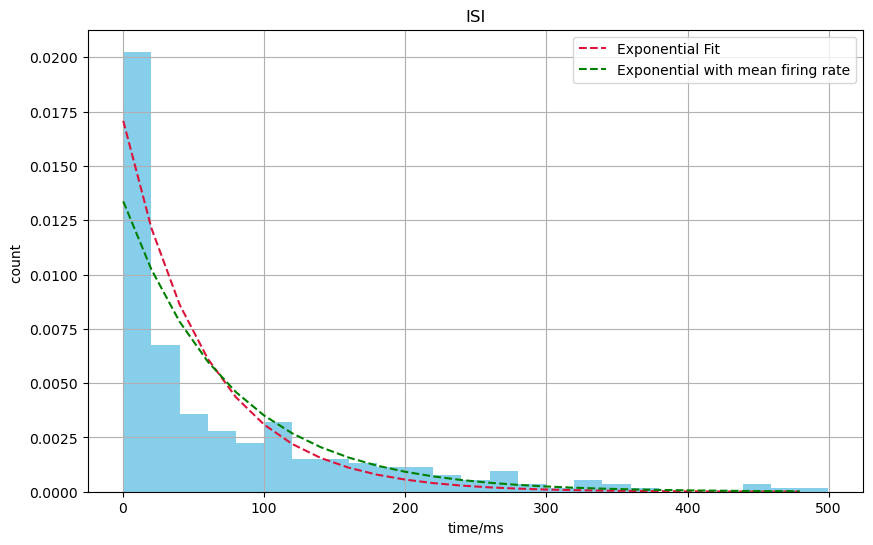

In [15]:
# plot the histgram of inter-spike interval
bin_num = 25
indices_of_1s = np.where(spike_record==1)[0]
#indices_of_1s = np.where(m_E_record==1)[0]
#print(indices_of_1s)
spike_intervals = [(indices_of_1s[i+1] - indices_of_1s[i]) * dt for i in range(len(indices_of_1s)-1)]
#print(spike_intervals)
#print(np.where(np.array(spike_intervals)< 10))
hist, bins = np.histogram(spike_intervals, bins=bin_num, density=True)
#print(hist, bins)
# Define exponential decay function
def exponential_decay_1(x, b):
    return b * np.exp(-b * x)

def exponential_decay_2(x, a, b):
    return a * np.exp(-b * x)

# Fit the histogram with exponential decay
popt, pcov = curve_fit(exponential_decay_1, bins[:-1], hist)
print(f'popt is {popt}')
print(f'r is { mean/delta_T}')
print(f' pcov is {pcov}')

# Plot histogram of intervals
plt.figure(figsize=(10, 6))
plt.hist(spike_intervals, bins = bin_num,color='skyblue', linewidth=1.2, density=True)
plt.plot(bins[:-1], exponential_decay_1(bins[:-1], *popt), color='crimson', label='Exponential Fit', ls='--')
plt.plot(bins[:-1], exponential_decay_1(bins[:-1], mean/delta_T), color='green', label='Exponential with mean firing rate', ls='--')
plt.xlabel('time/ms')
plt.xlabel('time/ms')
#plt.xlim(0, 175)
plt.ylabel('count ')
plt.title('ISI')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
hist, bins = np.histogram(spike_intervals, bins=10)

# Define exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Fit the histogram with exponential decay
popt, pcov = curve_fit(exponential_decay, bins[:-1], hist)

# Plot histogram
plt.hist(spike_intervals, bins=10, color='skyblue', edgecolor='black', linewidth=1.2, label='Histogram')

# Plot fitted curve
plt.plot(bins[:-1], exponential_decay(bins[:-1], *popt), color='red', label='Exponential Decay Fit')

plt.xlabel('Interval between 1s')
plt.ylabel('Frequency')
plt.title('Intervals between 1s')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
hey = np.random.binomial(100, 1 * 0.1, 20000)
print(sum(hey))
print(hey)

In [ ]:
a = np.array([[1]])
print(a.item())